In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import gym
import matplotlib.pyplot as plt

# Define the Q-network using PyTorch
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # initial exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check for GPU availability
        self.q_network = QNetwork(state_size, action_size).to(self.device)  # Move model to GPU
        self.target_network = QNetwork(state_size, action_size).to(self.device)  # Move model to GPU
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.FloatTensor(state).to(self.device)
        q_values = self.q_network(state)
        return q_values.argmax().item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.FloatTensor(np.array(states)).to(self.device)  # Convert to single numpy ndarray
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)  # Convert to single numpy ndarray
        dones = torch.FloatTensor(dones).to(self.device)

        q_values = self.q_network(states)
        q_values_next = self.target_network(next_states).max(1)[0].unsqueeze(1)
        q_targets = rewards + (1 - dones) * self.gamma * q_values_next

        loss = self.criterion(q_values.gather(1, actions.unsqueeze(1)), q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)




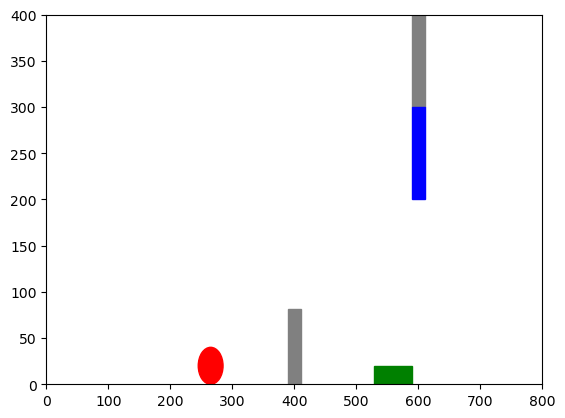

In [2]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# Constants
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 400
BAR_WIDTH = 20
BAR_HEIGHT = 100
BALL_RADIUS = 20
BASKET_WIDTH = 60
BASKET_HEIGHT = 20
MOVEMENT_SPEED = 5
VELOCITY = 10

class BallSortCraneEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(BallSortCraneEnv, self).__init__()

        # Define action and observation space
        self.action_space = spaces.Discrete(5)
        self.observation_space = spaces.Box(low=0, high=max(SCREEN_WIDTH, SCREEN_HEIGHT), shape=(6,), dtype=np.float32)

        # Initialize game variables
        self.bar_x = SCREEN_WIDTH - (SCREEN_WIDTH // 4)
        self.bar_y = SCREEN_HEIGHT - (SCREEN_HEIGHT // 4)
        self.bar_height = BAR_HEIGHT
        self.extend_bar = False
        self.shrink_bar = False
        self.move_left = False
        self.move_right = False
        self.score = 0
        self.is_grabbing = False
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        self.figure, self.ax = plt.subplots()
        self.current_step = 0
        self.initial_bar_height = BAR_HEIGHT
    def randomize_positions(self):
        ball_x = random.randint(BALL_RADIUS, SCREEN_WIDTH // 2 - BALL_RADIUS)
        basket_x = random.randint(SCREEN_WIDTH // 2 + BASKET_WIDTH // 2, SCREEN_WIDTH - BASKET_WIDTH // 2)
        max_pillar_height = SCREEN_HEIGHT // 2
        pillar_height = random.randint(50, max_pillar_height)
        ball_y = BALL_RADIUS
        basket_y = BASKET_HEIGHT // 2
        return ball_x, ball_y, basket_x, basket_y, pillar_height
    
    def is_better_position_for_grabbing(self):
        # Check if the bar is getting closer to the ball
        current_distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])
        is_getting_closer = current_distance_to_ball < self.previous_distance_to_ball
        
        # Check if extending the bar is beneficial for grabbing the ball
        is_correct_extension = self.extend_bar and self.bar_y - self.bar_height > self.ball_y

        return is_getting_closer or is_correct_extension

    def is_better_position_for_releasing(self):
        # Check if the bar (with the ball) is getting closer to the basket
        current_distance_to_basket = np.linalg.norm([self.basket_x - self.bar_x, self.basket_y - (self.bar_y - self.bar_height)])
        is_getting_closer = current_distance_to_basket < self.previous_distance_to_basket

        # Check if retracting the bar is beneficial for releasing the ball
        # This can be a simple condition based on the bar's position relative to the basket.
        is_correct_retraction = self.shrink_bar and self.ball_x == self.bar_x and self.bar_y - self.bar_height < self.basket_y

        return is_getting_closer or is_correct_retraction
    
    def step(self, action):

        if action == 0:  # Move Left
            self.move_left = True
            self.move_right = False
        elif action == 1:  # Move Right
            self.move_left = False
            self.move_right = True
        elif action == 2:  # Extend Bar
            self.extend_bar = True
            self.shrink_bar = False
        elif action == 3:  # Shrink Bar
            self.extend_bar = False
            self.shrink_bar = True
        elif action == 4:  # Grab/Release
            self.is_grabbing = not self.is_grabbing
        self.current_step += 1
        self.update_game_state()

        # Update previous distance to ball before updating game state
        self.previous_distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])

        self.update_game_state()

        reward = self.calculate_reward()
        done = self.is_game_done()
        obs = np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)

        return obs, reward, done, {}


    def reset(self):
        self.current_step = 0
        self.bar_x, self.bar_y, self.bar_height = SCREEN_WIDTH - (SCREEN_WIDTH // 4), SCREEN_HEIGHT - (SCREEN_HEIGHT // 4), BAR_HEIGHT
        self.extend_bar, self.shrink_bar, self.move_left, self.move_right, self.is_grabbing = False, False, False, False, False
        self.score = 0
        self.previous_distance_to_ball = float('inf')
        self.previous_distance_to_basket = float('inf')
        self.ball_x, self.ball_y, self.basket_x, self.basket_y, self.pillar_height = self.randomize_positions()
        self.initial_bar_height = self.bar_height
        return np.array([self.ball_x, self.ball_y, self.bar_x, self.bar_y, self.basket_x, self.basket_y], dtype=np.float32)
    

    def render(self, mode='human'):
        
        self.ax.clear()
        self.ax.set_xlim(0, SCREEN_WIDTH)
        self.ax.set_ylim(0, SCREEN_HEIGHT)

        # Draw the pillar in the middle of the screen
        pillar_x = SCREEN_WIDTH // 2
        pillar = patches.Rectangle((pillar_x - 10, 0), 20, self.pillar_height, color='gray')
        self.ax.add_patch(pillar)

        # Draw the crane's arm and bar
        crane_base_x = self.bar_x
        crane_base_y = SCREEN_HEIGHT
        crane_arm_length = SCREEN_HEIGHT - self.bar_y + self.bar_height
        crane_arm = patches.Rectangle((crane_base_x - BAR_WIDTH/2, self.bar_y), BAR_WIDTH, crane_arm_length, color='gray')
        self.ax.add_patch(crane_arm)
        bar = patches.Rectangle((self.bar_x - BAR_WIDTH/2, self.bar_y - self.bar_height), BAR_WIDTH, self.bar_height, color='blue')
        self.ax.add_patch(bar)

        # Draw the ball
        ball = patches.Circle((self.ball_x, self.ball_y), BALL_RADIUS, color='red')
        self.ax.add_patch(ball)

        # Draw the basket
        basket = patches.Rectangle((self.basket_x - BASKET_WIDTH/2, self.basket_y - BASKET_HEIGHT/2), BASKET_WIDTH, BASKET_HEIGHT, color='green')
        self.ax.add_patch(basket)
        
        if mode == 'rgb_array':
            # Convert the plot to an RGB array
            self.figure.canvas.draw()
            width, height = self.figure.get_size_inches() * self.figure.get_dpi()
            image = np.frombuffer(self.figure.canvas.tostring_rgb(), dtype='uint8')
            image = image.reshape(int(height), int(width), 3)
            return image
        elif mode == 'human':
            # [Existing code for human rendering]
            plt.draw()
            plt.pause(0.01)

    def close(self):
        plt.close(self.figure)

    def update_game_state(self):
        # Update bar position
        if self.move_left:
            self.bar_x = max(self.bar_x - MOVEMENT_SPEED, BAR_WIDTH / 2)
        if self.move_right:
            self.bar_x = min(self.bar_x + MOVEMENT_SPEED, SCREEN_WIDTH - BAR_WIDTH / 2)

        # Update bar height
        if self.extend_bar and self.bar_height < SCREEN_HEIGHT - self.bar_y:
            self.bar_height += 10
        if self.shrink_bar and self.bar_height > 10:
            self.bar_height -= 10

        # Handle ball grabbing logic
        if self.is_grabbing:
            # Check if the bar is above the ball
            if self.bar_x - BAR_WIDTH / 2 < self.ball_x < self.bar_x + BAR_WIDTH / 2 and \
               self.ball_y < self.bar_y - self.bar_height + BALL_RADIUS:
                self.ball_x = self.bar_x
                self.ball_y = self.bar_y - self.bar_height + BALL_RADIUS
        else:
            # Ball falls due to gravity
            if self.ball_y > BALL_RADIUS:
                self.ball_y -= VELOCITY
            else:
                self.ball_y = BALL_RADIUS  # Ensure ball doesn't go below the ground
                
    def is_ball_in_basket(self):
        # Check if the ball is within the horizontal boundaries of the basket
        ball_in_basket_horizontally = (self.ball_x + BALL_RADIUS > self.basket_x - BASKET_WIDTH / 2) and \
                                      (self.ball_x - BALL_RADIUS < self.basket_x + BASKET_WIDTH / 2)

        # Check if the ball is within the vertical boundaries of the basket
        ball_in_basket_vertically = (self.ball_y - BALL_RADIUS < self.basket_y + BASKET_HEIGHT / 2) and \
                                    (self.ball_y + BALL_RADIUS > self.basket_y - BASKET_HEIGHT / 2)

        # The ball is in the basket if it's within both horizontal and vertical boundaries
        return ball_in_basket_horizontally and ball_in_basket_vertically
    def is_directly_above_ball(self):
            # Define a threshold for being considered 'directly above'
            threshold = 10  # Adjust this value as needed

            # Check if the bar's horizontal position is close enough to the ball's position
            return abs(self.bar_x - self.ball_x) < threshold and self.ball_y < self.bar_y - self.bar_height
    def calculate_reward(self):
        # Calculate the current distance to the ball
        current_distance_to_ball = np.linalg.norm([self.ball_x - self.bar_x, self.ball_y - (self.bar_y - self.bar_height)])
        
        # Reward if the crane moves closer to the ball, else penalize
        if current_distance_to_ball < self.previous_distance_to_ball:
            reward = 1  # Positive reward for moving closer
        else:
            reward = -1  # Negative reward for moving away

        # Update the previous distance for the next step
        self.previous_distance_to_ball = current_distance_to_ball

        return reward

    def is_game_done(self):
        max_score = 50
        max_steps = 1000
        ball_in_basket = self.is_ball_in_basket()
        return self.score >= max_score or self.current_step >= max_steps or ball_in_basket


# Create and test your environment
env = BallSortCraneEnv()
env.reset()
env.render()

In [5]:
import imageio
import base64
import IPython
import gym
import numpy as np
import torch

# Function to embed the video in the notebook
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4">
        Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)


# Define state_size and action_size based on your environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# Initialize the agent
agent = DQNAgent(state_size, action_size)

# Load the trained model
model_path = 'dqn_model.pth'  # Adjust the path to your trained model file
agent.q_network.load_state_dict(torch.load(model_path))
agent.q_network.eval()  # Set the model to evaluation mode

# Define the number of episodes and video filename
num_episodes = 3
video_filename = 'ball_sort_crane_gameplay.mp4'

# Create a video writer
with imageio.get_writer(video_filename, fps=60) as video:
    for _ in range(num_episodes):
        state = env.reset()
        video.append_data(env.render(mode='rgb_array'))
        done = False
        while not done:
            state = np.reshape(state, [1, state_size])
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            state = next_state
            video.append_data(env.render(mode='rgb_array'))

# Embed the video in the notebook
embed_mp4(video_filename)